# SNN on MNIST

In this notebook I train a Spiking Neural network on the MNIST dataset


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/{user_name}/{repo_name}/blob/{branch_name}/mnist.ipynb)

Clone git repository for execution on google colab

In [ ]:
!git clone git@github.com:CSteennis/BscThesis.git

In [1]:
%pip install snntorch
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



### Imports

In [2]:

import matplotlib.pyplot as plt
import snntorch.functional as sf
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchmetrics.classification import MulticlassAccuracy

from snn_net import Net
from snn_net import train

### Helper functions to import data and plot the accuracy

In [3]:

def import_data():
    # Define a transform
    transform = transforms.Compose([
                transforms.Resize((28,28)),
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0,), (1,))])
    
    # gather data
    mnist_train = datasets.MNIST("/dataset/", train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST("/dataset/", train=False, download=True, transform=transform)
    
    # create batches
    train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size=64) 
    
    return train_loader, test_loader


In [4]:

def plot_accuracy(acc_hist, title, test=False):
    fig, ax = plt.subplots()
    ax.plot(acc_hist)
    ax.set_title(title)
    ax.set_xlabel("Epoch" if test else "Batch")
    ax.set_ylabel("Accuracy")
    fig.savefig("images/"+title+"_MNIST.svg", format='svg')

def plot_loss(loss_hist, title):
    fig, ax = plt.subplots()
    ax.plot(loss_hist)
    ax.set_title(title)
    ax.set_xlabel("Batch")
    ax.set_ylabel("Loss")
    fig.savefig("images/"+title+"_MNIST.svg", format='svg')


### Hyper parameters

In [5]:

# number of epochs
epochs = 10

# number of time steps
n_steps = 25 #ms

# neuron counts
inputs = 28 * 28
hiddens = 200
outputs = 10

# membrane potential decay
decay = 0.9


In [6]:

# import training and test data
train_loader, test_loader = import_data()


### Train command for the snn

#### Encoding schemes

##### Rate encoded

In [7]:

print("SNN rate:")

# initialize net
rate_snn = Net(inputs, hiddens, outputs, decay, n_steps, enc_type='rate')

# optimization algoritm
optimizer = torch.optim.Adam(rate_snn.parameters()) # (NOTE: Adam stond in de tutorial misschien beter algoritme)

# loss function
loss_fn = sf.ce_count_loss() # type: ignore

# accuracy function
accuracy = sf.accuracy_rate

test_acc_snn_rate = train(rate_snn, optimizer, loss_fn, accuracy, train_loader, test_loader, epochs)


SNN rate:


Epoch 0: 100%|██████████| 469/469 [01:05<00:00,  7.13batch/s, accuracy=96.88, loss=0.104] 


Test accuracy: 96.33%


Epoch 1: 100%|██████████| 469/469 [01:01<00:00,  7.57batch/s, accuracy=100.00, loss=0.0174] 


Test accuracy: 96.91%


Epoch 2: 100%|██████████| 469/469 [00:58<00:00,  7.96batch/s, accuracy=100.00, loss=0.0157] 


Test accuracy: 97.22%


Epoch 3: 100%|██████████| 469/469 [00:54<00:00,  8.54batch/s, accuracy=100.00, loss=0.00577]


Test accuracy: 97.58%


Epoch 4: 100%|██████████| 469/469 [00:55<00:00,  8.43batch/s, accuracy=98.96, loss=0.0391]   


Test accuracy: 97.64%


Epoch 5: 100%|██████████| 469/469 [00:57<00:00,  8.19batch/s, accuracy=100.00, loss=0.00639]


Test accuracy: 97.58%


Epoch 6: 100%|██████████| 469/469 [00:58<00:00,  8.05batch/s, accuracy=97.92, loss=0.0572]  


Test accuracy: 97.44%


Epoch 7: 100%|██████████| 469/469 [00:59<00:00,  7.86batch/s, accuracy=96.88, loss=0.0496]   


Test accuracy: 97.76%


Epoch 8: 100%|██████████| 469/469 [01:00<00:00,  7.77batch/s, accuracy=98.96, loss=0.0747]   


Test accuracy: 97.56%


Epoch 9: 100%|██████████| 469/469 [00:58<00:00,  7.98batch/s, accuracy=98.96, loss=0.0229]   


Test accuracy: 97.24%


##### Time encoded

In [8]:

print("SNN temporal:")

# initialize net
temp_snn = Net(inputs, hiddens, outputs, decay, n_steps, 'latency')

# optimization algoritm
optimizer = torch.optim.Adam(temp_snn.parameters()) # (NOTE: Adam stond in de tutorial misschien beter algoritme)

# loss function
loss_fn = sf.ce_temporal_loss() # type: ignore

# accuracy function
accuracy = sf.accuracy_temporal

test_acc_snn_temp = train(temp_snn, optimizer, loss_fn, accuracy, train_loader, test_loader, epochs)


SNN temporal:


Epoch 0: 100%|██████████| 469/469 [01:06<00:00,  7.09batch/s, accuracy=93.75, loss=0.258]


Test accuracy: 87.78%


Epoch 1: 100%|██████████| 469/469 [01:05<00:00,  7.21batch/s, accuracy=93.75, loss=0.226]


Test accuracy: 92.65%


Epoch 2: 100%|██████████| 469/469 [01:01<00:00,  7.61batch/s, accuracy=95.83, loss=0.175] 


Test accuracy: 93.74%


Epoch 3: 100%|██████████| 469/469 [01:06<00:00,  7.05batch/s, accuracy=94.79, loss=0.128]  


Test accuracy: 94.73%


Epoch 4: 100%|██████████| 469/469 [01:04<00:00,  7.24batch/s, accuracy=94.79, loss=0.254] 


Test accuracy: 95.60%


Epoch 5: 100%|██████████| 469/469 [01:06<00:00,  7.10batch/s, accuracy=95.83, loss=0.115]  


Test accuracy: 95.31%


Epoch 6: 100%|██████████| 469/469 [01:05<00:00,  7.11batch/s, accuracy=100.00, loss=0.0173]


Test accuracy: 96.02%


Epoch 7: 100%|██████████| 469/469 [01:13<00:00,  6.39batch/s, accuracy=95.83, loss=0.15]   


Test accuracy: 96.72%


Epoch 8: 100%|██████████| 469/469 [01:14<00:00,  6.33batch/s, accuracy=95.83, loss=0.105]   


Test accuracy: 96.26%


Epoch 9: 100%|██████████| 469/469 [01:14<00:00,  6.33batch/s, accuracy=97.92, loss=0.0686] 


Test accuracy: 96.79%


#### Test net on single img

In [1]:

test_acc, loss_hist, acc_hist = test_acc_snn_rate

plot_accuracy(acc_hist, "Train-accuracy")
plot_loss(loss_hist, "Train-loss")
plot_accuracy(test_acc, "Test-accuracy", test=True)


NameError: name 'test_acc_snn_rate' is not defined

In [ ]:

data = next(iter(train_loader))[0].squeeze()

img = 0

plt.imshow(data[img],cmap="Greys")

output = rate_snn.forward(data.flatten(1))

fig, ax = plt.subplots(5,2)

for i in range(5):
    for j in range(2):
        ax[i][j].plot(output[:,img,2*i+j].detach().numpy())
        ax[i][j].set_title(f'{2*i+j}')
        ax[i][j].set_ybound(-0.2,1.2)

fig.tight_layout()


### Train command for Feed Forward net

In [9]:

feed_fwd_net = nn.Sequential(nn.Linear(inputs, hiddens),
                            nn.ReLU(),
                            nn.Linear(hiddens, outputs))

# optimization algoritm
optimizer = torch.optim.Adam(feed_fwd_net.parameters()) # (NOTE: Adam stond in de tutorial misschien beter algoritme)

# loss function
loss_fn = nn.CrossEntropyLoss()

# accuracy function
accuracy = MulticlassAccuracy(num_classes=outputs)

print("FFN:")
test_acc_feed = train(feed_fwd_net, optimizer, loss_fn, accuracy, train_loader, test_loader, epochs)


FFN:


Epoch 0: 100%|██████████| 469/469 [00:20<00:00, 23.23batch/s, accuracy=91.66, loss=0.236]


Test accuracy: 94.18%


Epoch 1: 100%|██████████| 469/469 [00:18<00:00, 25.30batch/s, accuracy=99.00, loss=0.0463]


Test accuracy: 95.69%


Epoch 2: 100%|██████████| 469/469 [00:18<00:00, 26.02batch/s, accuracy=96.79, loss=0.19]   


Test accuracy: 96.58%


Epoch 3: 100%|██████████| 469/469 [00:18<00:00, 24.78batch/s, accuracy=96.66, loss=0.126]  


Test accuracy: 97.12%


Epoch 4: 100%|██████████| 469/469 [00:19<00:00, 23.94batch/s, accuracy=97.09, loss=0.0875] 


Test accuracy: 97.43%


Epoch 5: 100%|██████████| 469/469 [00:17<00:00, 27.02batch/s, accuracy=99.38, loss=0.0668] 


Test accuracy: 97.50%


Epoch 6: 100%|██████████| 469/469 [00:22<00:00, 21.29batch/s, accuracy=99.29, loss=0.0343]  


Test accuracy: 97.33%


Epoch 7: 100%|██████████| 469/469 [00:20<00:00, 22.92batch/s, accuracy=98.33, loss=0.0249]  


Test accuracy: 97.55%


Epoch 8: 100%|██████████| 469/469 [00:18<00:00, 24.86batch/s, accuracy=100.00, loss=0.0172] 


Test accuracy: 97.57%


Epoch 9: 100%|██████████| 469/469 [00:21<00:00, 21.89batch/s, accuracy=99.23, loss=0.025]   


Test accuracy: 97.59%


### Comparison

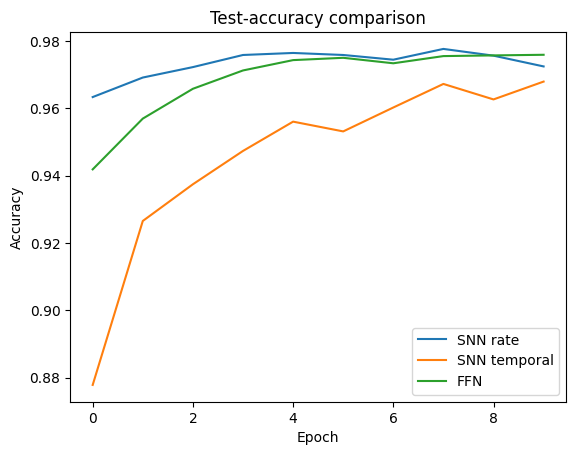

In [11]:

fig, ax = plt.subplots()
ax.plot(test_acc_snn_rate[0], label="SNN rate")
ax.plot(test_acc_snn_temp[0], label="SNN temporal")
ax.plot(test_acc_feed[0], label="FFN")
ax.set_title("Test-accuracy comparison")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
fig.savefig("images/Comparison_MNIST.svg", format='svg')
